In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

# Import scikit-learn metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import random

#Import dataset from Kaggle

In [ ]:
!pip install q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'akbariffianto/final-skin-disease'

Dataset URL: https://www.kaggle.com/datasets/akbariffianto/final-skin-disease
License(s): apache-2.0
100% 4.34G/4.35G [00:51<00:00, 86.6MB/s]
100% 4.35G/4.35G [00:51<00:00, 90.8MB/s]


In [ ]:
import zipfile

zip_file_path = 'final-skin-disease.zip'

extract_dir = 'dataset'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")

Files extracted to: dataset


#Data Wrangling

##Data Gathering

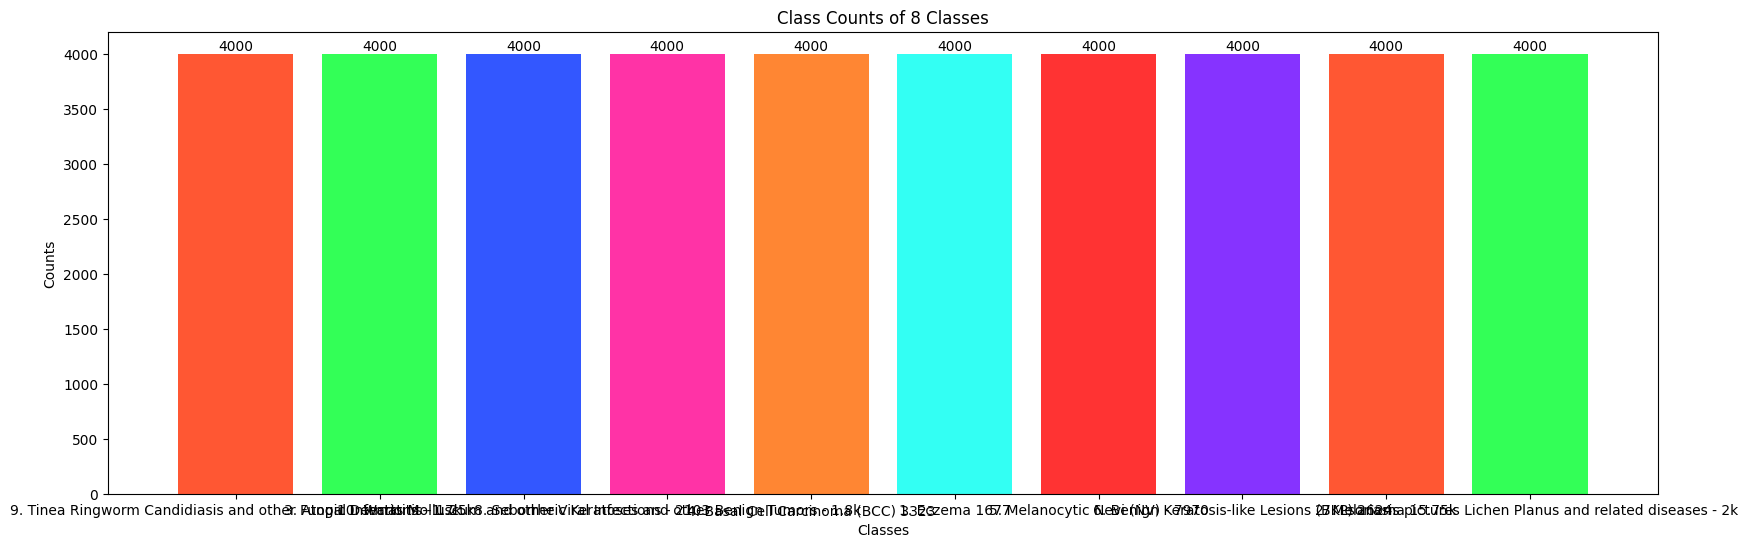

In [ ]:
data_path = 'dataset'
classes = os.listdir(data_path) # names of folders are the names of classes
class_counts = [len(os.listdir(data_path + '/' + x)) for x in classes] # length of respective classes is the count of images available for the respective class
#print(class_counts)
plt.figure(figsize=(20, 6))
bars = plt.bar(classes, class_counts, color = ['#FF5733', '#33FF57', '#3357FF', '#FF33A6', '#FF8633', '#33FFF3', '#FF3333', '#8633FF']) # 8 random colors chosen for better visualisation
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
# Code to display count of each class on top of respective bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )

In [ ]:
class_mapping = {
    'Fungal infection': 'Fungal Infections (Tinea/Ringworm)',
    'Eczema': 'Atopic Dermatitis (Eczema)',
    'Viral infection': 'Viral Infections (Warts/Molluscum)',
    'Benign tumors': 'Benign Tumors (Seborrheic Keratoses)',
    'Skin cancer': 'Skin Cancer (Basal Cell Carcinoma)',
    'eczema': 'Eczema (General)',
    'Benign moles': 'Benign Moles (Melanocytic Nevi)',
    'Benign lesions': 'Benign Lesions (Keratosis-like)',
    'melanoma': 'Skin Cancer (Melanoma)',
    'psoriasis': 'Chronic Skin Diseases (Psoriasis/Lichen Planus)'
}


new_classes = []
for class_name in classes:
    new_class_name = class_mapping.get(class_name, class_name)
    new_classes.append(new_class_name)

#Splitting Dataset

In [ ]:
import random
import shutil

train_path = "train"
val_path = "val"
test_path = "test"

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

train_ratio = 0.80
val_ratio = 0.15
test_ratio = 0.05

for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)

    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val

    train_images = images[:num_train]
    val_images = images[num_train:num_train+num_val]
    test_images = images[num_train+num_val:]

    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))

    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))

    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Dataset split completed successfully.")

Dataset split completed successfully.


In [ ]:
train_counts = [len(os.listdir(os.path.join(train_path, class_folder))) for class_folder in os.listdir(train_path)]
val_counts = [len(os.listdir(os.path.join(val_path, class_folder))) for class_folder in os.listdir(val_path)]
test_counts = [len(os.listdir(os.path.join(test_path, class_folder))) for class_folder in os.listdir(test_path)]

print("Number of files in Train:", sum(train_counts))
print("Number of files in Validation:", sum(val_counts))
print("Number of files in Test:", sum(test_counts))

Number of files in Train: 32000
Number of files in Validation: 6000
Number of files in Test: 2000


#Preparing Training and Validation

In [ ]:
val_path = "val"
train_path = "train"
img_size =(128,128)
batch_size = 32
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    color_mode="rgb"
)
class_names = train_dataset.class_names
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    color_mode="rgb"
)

Found 32000 files belonging to 10 classes.
Found 6000 files belonging to 10 classes.


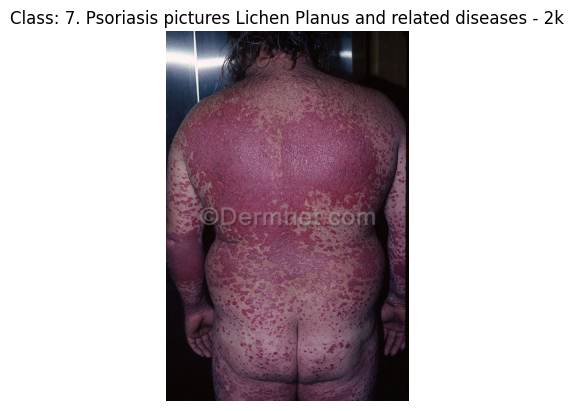

In [ ]:
# Choose a random class
class_names = os.listdir(train_path)
random_class = random.choice(class_names)
class_path = os.path.join(train_path, random_class)

# Choose a random image from the chosen class
image_files = os.listdir(class_path)
random_image_file = random.choice(image_files)
image_path = os.path.join(class_path, random_image_file)

# Display the image and its label
try:
  img = plt.imread(image_path)
  plt.imshow(img)
  plt.title(f"Class: {random_class}")
  plt.axis('off')  # Hide axis ticks and labels
  plt.show()
except FileNotFoundError:
  print(f"Error: Image file not found at {image_path}")
except Exception as e:
  print(f"An error occurred: {e}")

#Create Model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Augmented Model with L2 Regularization
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    tf.keras.layers.Rescaling(1./255),

    # First convolution with kernel regularization
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # First convolution with kernel regularization
    tf.keras.layers.Conv2D(224, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),  # Dropout for regularization

    # First convolution with kernel regularization
    tf.keras.layers.Conv2D(320, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  # Dropout for regularization
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_16 (Rescaling)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 126, 126, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 61, 61, 224)         │         258,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 30, 30, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 30, 30, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 28, 28, 320)         │         645,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 14, 14, 320)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 32)                  │       2,007,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,914,698 (11.12 MB)

 Trainable params: 2,914,698 (11.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 256, 256, 3)
Output shape: (None, 10)


#Training Model

In [ ]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[reduce_lr]
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 221s 111ms/step - accuracy: 0.0991 - loss: 2.3246 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 2/50
 237/1000 ━━━━━━━━━━━━━━━━━━━━ 1:10 93ms/step - accuracy: 0.0996 - loss: 2.3029

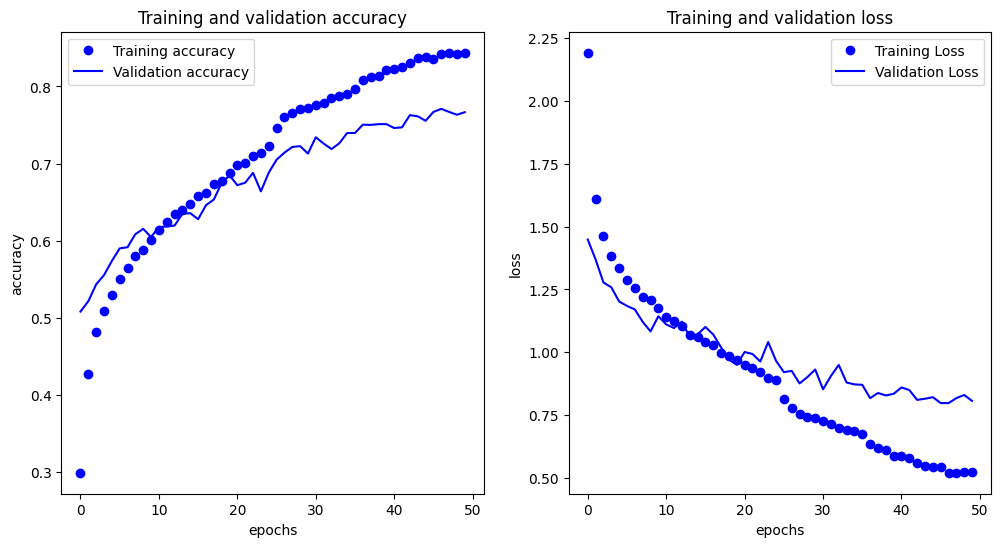

In [ ]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

#Evaluasi Model

Found 2000 files belonging to 10 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step
Confusion matrix, without normalization
[[151   7   0   1   0   0   0  34   2   5]
 [  6 156   0   3   0   2   1  24   5   3]
 [  0   0 177   0   1  18   2   1   0   1]
 [ 15  12   0 136   0   0   0  26   3   8]
 [  2   0   4   0 178   5  10   0   1   0]
 [  0   1   4   0   3 181  10   1   0   0]
 [  0   0   5   1  25  17 145   2   4   1]
 [ 13   8   0   7   0   0   0 155   7  10]
 [  6  16   0   0   0   0   1  15 158   4]
 [ 16  11   0   5   0   0   0  31   0 137]]


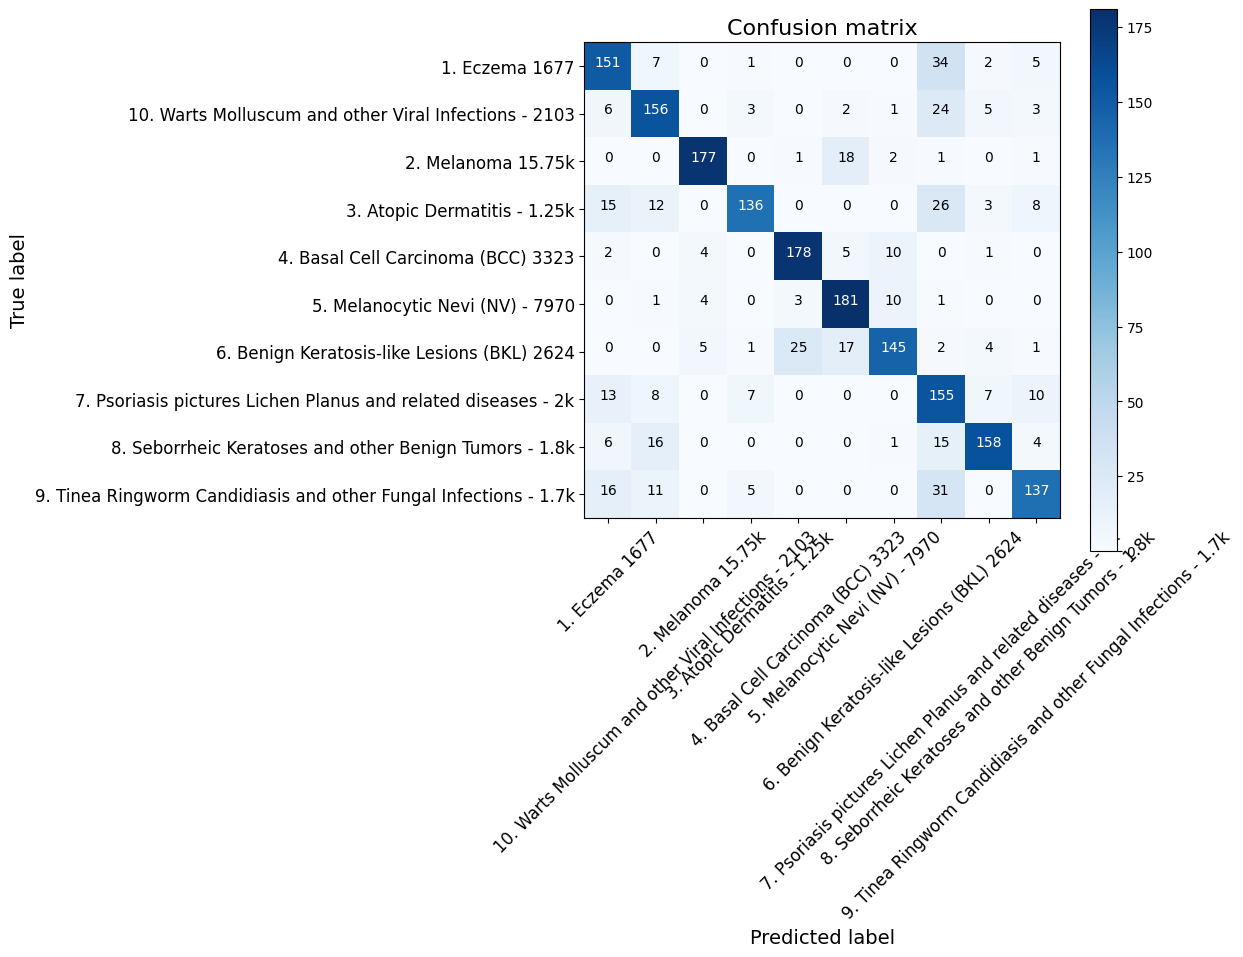

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       200
           1       0.74      0.78      0.76       200
           2       0.93      0.89      0.91       200
           3       0.89      0.68      0.77       200
           4       0.86      0.89      0.87       200
           5       0.81      0.91      0.86       200
           6       0.86      0.72      0.79       200
           7       0.54      0.78      0.63       200
           8       0.88      0.79      0.83       200
           9       0.81      0.69      0.74       200

    accuracy                           0.79      2000
   macro avg       0.80      0.79      0.79      2000
weighted avg       0.80      0.79      0.79      2000



In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=10)

    plt.tight_layout(pad=2.0)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.show()


import itertools
test_path = 'test'
test_dataset = image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42,
    label_mode='categorical',
    color_mode="rgb",
    shuffle=False
)

y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.concatenate([y for x,y in test_dataset], axis = 0)
y_true = np.argmax(y_true, axis = 1)

cm = confusion_matrix(y_true, y_pred_classes)

plot_confusion_matrix(cm, classes=class_names)
print(classification_report(y_true, y_pred_classes))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_path = 'test'

test_dataset = image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

labels = []
predictions = []
for x,y in test_dataset:
    labels.append(list(y.numpy().astype("uint8")))
    predictions.append(tf.argmax(model.predict(x),1).numpy().astype("uint8"))
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))
print('F1 score:', f1_score(labels, predictions, average='micro'))

Found 2000 files belonging to 10 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

import pandas as pd
report_df = pd.DataFrame(report).transpose()

print("Classification Metrics:")
print(report_df[['precision', 'recall', 'f1-score']])

report_df.to_csv('classification_report.csv', index=True)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step
Classification Metrics:
                                                    precision  recall  \
1. Eczema 1677                                       0.722488   0.755   
10. Warts Molluscum and other Viral Infections ...   0.739336   0.780   
2. Melanoma 15.75k                                   0.931579   0.885   
3. Atopic Dermatitis - 1.25k                         0.888889   0.680   
4. Basal Cell Carcinoma (BCC) 3323                   0.859903   0.890   
5. Melanocytic Nevi (NV) - 7970                      0.811659   0.905   
6. Benign Keratosis-like Lesions (BKL) 2624          0.857988   0.725   
7. Psoriasis pictures Lichen Planus and related...   0.536332   0.775   
8. Seborrheic Keratoses and other Benign Tumors...   0.877778   0.790   
9. Tinea Ringworm Candidiasis and other Fungal ...   0.810651   0.685   
accuracy                                             0.787000   0.787   
macro avg                                            0.8036

Saving salah-kaprah-pemberian-antibiotik-untuk-dyshidrotic-eczema.jpg to salah-kaprah-pemberian-antibiotik-untuk-dyshidrotic-eczema.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
salah-kaprah-pemberian-antibiotik-untuk-dyshidrotic-eczema.jpg
[[6.7503136e-01 2.0608960e-02 4.0872612e-05 1.8471251e-01 3.3164011e-05
  3.8987105e-06 1.1584045e-06 8.9115016e-02 9.3646627e-04 2.9516622e-02]]
Predicted Class: 1. Eczema 1677


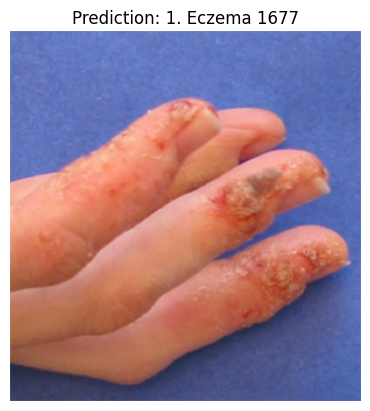

In [ ]:
from google.colab import files
import tensorflow as tf
import numpy as np
from PIL import Image

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = tf.keras.utils.load_img(path, target_size=(256, 256))
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)
  predicted_class_index = np.argmax(classes[0])
  predicted_class_name = class_names[predicted_class_index]
  print("Predicted Class:", predicted_class_name)

  img = Image.open(path)
  plt.imshow(img)
  plt.title(f"Prediction: {predicted_class_name}")
  plt.axis("off")
  plt.show()

#Simpan Model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('skin_disease_model.tflite', 'wb') as f:
  f.write(tflite_model)

print("TensorFlow Lite model saved successfully!")

Saved artifact at '/tmp/tmpz_lgg70x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_56')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134076753224528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134076595395344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134076595395872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134076595397104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134076595393232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134076595394112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134076102652176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134076102643024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134076102652352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134076102654112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1340761026

In [ ]:
# Save the model in the native Keras format
model.save('79_Skin Disease.keras')

print("Model saved successfully in Keras format!")

TypeError: cannot pickle 'module' object